In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from ignite.engine import Events, Engine
from ignite.metrics import Average, Loss
from ignite.contrib.handlers import ProgressBar

import gpytorch
from gpytorch.mlls import VariationalELBO
from gpytorch.likelihoods import GaussianLikelihood

from due.dkl import DKL, GP, initial_values
from due.sngp import Laplace
from due.fc_resnet import FCResNet

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_palette("colorblind")

/home/xl/anaconda3/envs/xuelong-torch/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:15: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
def make_data(n_samples, noise=0.05, seed=2):
    # make some random sines & cosines
    np.random.seed(seed)
    n_samples = int(n_samples)
    
    W = np.random.randn(30, 1)
    b = np.random.rand(30, 1) * 2 * np.pi
    
    x = 5 * np.sign(np.random.randn(n_samples)) + np.random.randn(n_samples).clip(-2, 2)
    y = np.cos(W * x + b).sum(0) + noise * np.random.randn(n_samples)
    return x[..., None], y

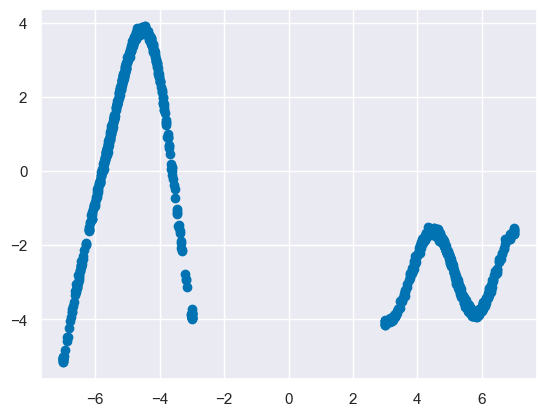

In [3]:
n_samples = 1e3
# n_samples = 1e6

domain = 15

x, y = make_data(n_samples)
plt.scatter(x, y)

In [4]:
np.random.seed(0)
torch.manual_seed(0)

batch_size = 128

X_train, y_train = make_data(n_samples)
X_test, y_test = X_train, y_train

ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)

ds_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=512, shuffle=False)

steps = 5e3
epochs = steps // len(dl_train) + 1
print(f"Training with {n_samples} datapoints for {epochs} epochs")

# Change this boolean to False for SNGP
DUE = True

input_dim = 1
features = 128
depth = 4
num_outputs = 1 # regression with 1D output
spectral_normalization = True
coeff = 0.95
n_power_iterations = 1
dropout_rate = 0.01

feature_extractor = FCResNet(
    input_dim=input_dim, 
    features=features, 
    depth=depth, 
    spectral_normalization=spectral_normalization, 
    coeff=coeff, 
    n_power_iterations=n_power_iterations,
    dropout_rate=dropout_rate
)

if DUE:
    n_inducing_points = 20
    kernel = "RBF"
    
    initial_inducing_points, initial_lengthscale = initial_values(
            ds_train, feature_extractor, n_inducing_points
    )

    gp = GP(
        num_outputs=num_outputs,
        initial_lengthscale=initial_lengthscale,
        initial_inducing_points=initial_inducing_points,
        kernel=kernel,
    )

    model = DKL(feature_extractor, gp)

    likelihood = GaussianLikelihood()
    elbo_fn = VariationalELBO(likelihood, model.gp, num_data=len(ds_train))
    loss_fn = lambda x, y: -elbo_fn(x, y)
else:
    num_gp_features = 128
    num_random_features = 1024
    normalize_gp_features = True
    feature_scale = 2
    ridge_penalty = 1
    
    model = Laplace(feature_extractor,
                    features,
                    num_gp_features,
                    normalize_gp_features,
                    num_random_features,
                    num_outputs,
                    len(ds_train),
                    batch_size,
                    ridge_penalty=ridge_penalty,
                    feature_scale=feature_scale
                   )

    loss_fn = F.mse_loss

if torch.cuda.is_available():
    model = model.cuda()
    if DUE:
        likelihood = likelihood.cuda()
    
lr = 1e-3

parameters = [
    {"params": model.parameters(), "lr": lr},
]

if DUE:
    parameters.append({"params": likelihood.parameters(), "lr": lr})
    
    
optimizer = torch.optim.Adam(parameters)
pbar = ProgressBar()

def step(engine, batch):
    model.train()
    if DUE:
        likelihood.train()
    
    optimizer.zero_grad()
    
    x, y = batch
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    y_pred = model(x)
    
    if not DUE:
        y_pred.squeeze_()

    loss = loss_fn(y_pred, y)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()


def eval_step(engine, batch):
    model.eval()
    if DUE:
        likelihood.eval()
    
    x, y = batch
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    y_pred = model(x)
            
    return y_pred, y

    
trainer = Engine(step)
evaluator = Engine(eval_step)

metric = Average()
metric.attach(trainer, "loss")
pbar.attach(trainer)

if DUE:
    metric = Loss(lambda y_pred, y: - likelihood.expected_log_prob(y, y_pred).mean())
else:
    metric = Loss(lambda y_pred, y: F.mse_loss(y_pred[0].squeeze(), y))


metric.attach(evaluator, "loss")

@trainer.on(Events.EPOCH_COMPLETED(every=int(epochs/10) + 1))
def log_results(trainer):
    evaluator.run(dl_test)
    print(f"Results - Epoch: {trainer.state.epoch} - "
          f"Test Likelihood: {evaluator.state.metrics['loss']:.2f} - "
          f"Loss: {trainer.state.metrics['loss']:.2f}")

    
if not DUE:
    @trainer.on(Events.EPOCH_STARTED)
    def reset_precision_matrix(trainer):
        model.reset_precision_matrix()

Training with 1000.0 datapoints for 715.0 epochs


/home/xl/anaconda3/envs/xuelong-torch/lib/python3.12/site-packages/ignite/handlers/tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [5]:
trainer.run(dl_train, max_epochs=epochs)

Results - Epoch: 72 - Test Likelihood: 2.78 - Loss: 2.83


Results - Epoch: 144 - Test Likelihood: 1.72 - Loss: 1.75


Results - Epoch: 216 - Test Likelihood: 1.35 - Loss: 1.39


Results - Epoch: 288 - Test Likelihood: 1.18 - Loss: 1.23


Results - Epoch: 360 - Test Likelihood: 1.10 - Loss: 1.15


Results - Epoch: 432 - Test Likelihood: 1.01 - Loss: 1.07


Results - Epoch: 504 - Test Likelihood: 0.91 - Loss: 0.97


Results - Epoch: 576 - Test Likelihood: 0.82 - Loss: 0.85


Results - Epoch: 648 - Test Likelihood: 0.59 - Loss: 0.67


State:
	iteration: 5005
	epoch: 715
	epoch_length: 7
	max_epochs: 715.0
	output: 0.5212604403495789
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [6]:
model.eval()
if DUE:
    likelihood.eval()

x_lin = np.linspace(-domain, domain, 100)
            
with torch.no_grad(), gpytorch.settings.num_likelihood_samples(64):
    xx = torch.tensor(x_lin[..., None]).float()
    if torch.cuda.is_available():
        xx = xx.cuda()
    pred = model(xx)

    if DUE:
        ol = likelihood(pred)
        output = ol.mean.cpu()
        output_std = ol.stddev.cpu()
    else:
        output = pred[0].squeeze().cpu()
        output_var = pred[1].diagonal()
        output_std = output_var.sqrt().cpu()

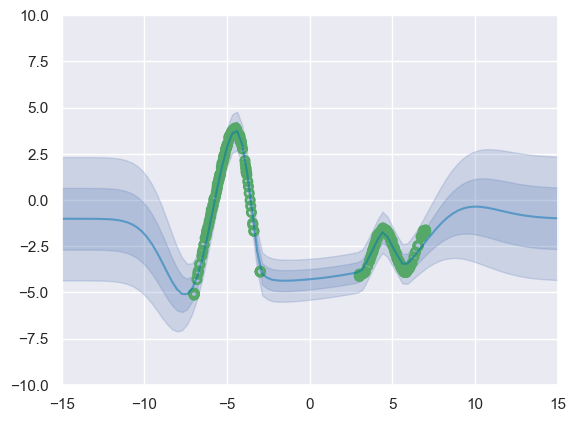

In [8]:
plt.xlim(-domain, domain)
plt.ylim(-10, 10)
plt.fill_between(x_lin, output - output_std, output + output_std, alpha=0.2, color='b')
plt.fill_between(x_lin, output - 2 * output_std, output + 2 * output_std, alpha=0.2, color='b')

plt.scatter([], [])
plt.scatter([], [])
X_vis, y_vis = make_data(n_samples=300)

plt.scatter(X_vis.squeeze(), y_vis, facecolors='none', edgecolors='g', linewidth=2)
plt.plot(x_lin, output, alpha=0.5)

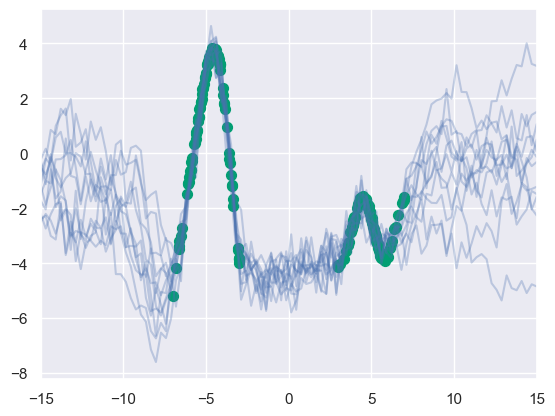

In [9]:
plt.xlim(-domain, domain)

for i in range(12):
    plt.plot(x_lin, ol.rsample().cpu(), alpha=0.3, color='b')
    
plt.scatter([], [])
plt.scatter([], [])
X_vis, y_vis = make_data(n_samples=200)
plt.scatter(X_vis.squeeze(), y_vis, s=50)

In [10]:
# Inspired by https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html
# only works on 1,000 samples

train_x, train_y = torch.tensor(x).float(), torch.tensor(y).float()

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = GaussianLikelihood()
exact_gp = ExactGPModel(train_x, train_y, likelihood)

exact_gp.train()
likelihood.train()

optimizer = torch.optim.Adam(exact_gp.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, exact_gp)

training_iter = 100

for i in range(training_iter):
    optimizer.zero_grad()
    output = exact_gp(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        exact_gp.covar_module.base_kernel.lengthscale.item(),
        exact_gp.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 0.838   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 0.786   lengthscale: 0.744   noise: 0.644
Iter 3/100 - Loss: 0.745   lengthscale: 0.728   noise: 0.598
Iter 4/100 - Loss: 0.705   lengthscale: 0.698   noise: 0.554
Iter 5/100 - Loss: 0.661   lengthscale: 0.698   noise: 0.513
Iter 6/100 - Loss: 0.619   lengthscale: 0.715   noise: 0.474
Iter 7/100 - Loss: 0.582   lengthscale: 0.742   noise: 0.437
Iter 8/100 - Loss: 0.530   lengthscale: 0.770   noise: 0.402
Iter 9/100 - Loss: 0.497   lengthscale: 0.782   noise: 0.370
Iter 10/100 - Loss: 0.446   lengthscale: 0.793   noise: 0.340
Iter 11/100 - Loss: 0.399   lengthscale: 0.800   noise: 0.312
Iter 12/100 - Loss: 0.360   lengthscale: 0.811   noise: 0.285
Iter 13/100 - Loss: 0.313   lengthscale: 0.809   noise: 0.261
Iter 14/100 - Loss: 0.270   lengthscale: 0.797   noise: 0.238
Iter 15/100 - Loss: 0.225   lengthscale: 0.784   noise: 0.218
Iter 16/100 - Loss: 0.182   lengthscale: 0.784   noise: 0.198
Iter 17/100 - Los

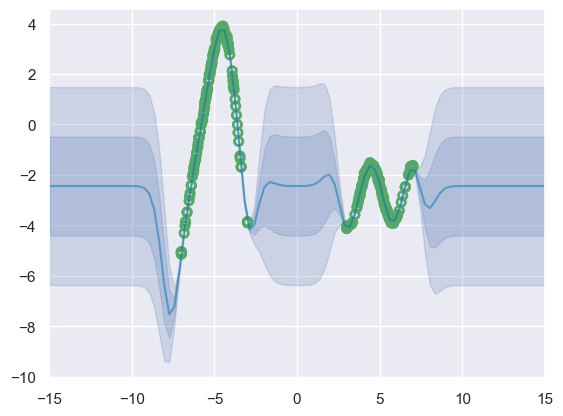

In [11]:
exact_gp.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-domain, domain, 100)
    observed_pred = likelihood(exact_gp(test_x))


    output = observed_pred.mean
    output_std = observed_pred.stddev

plt.xlim(-domain, domain)
plt.fill_between(x_lin, output - output_std, output + output_std, alpha=0.2, color='b')
plt.fill_between(x_lin, output - 2 * output_std, output + 2 * output_std, alpha=0.2, color='b')

plt.scatter([], [])
plt.scatter([], [])
X_vis, y_vis = make_data(n_samples=300)

plt.scatter(X_vis.squeeze(), y_vis, facecolors='none', edgecolors='g', linewidth=2)
plt.plot(x_lin, output, alpha=0.5)